# 03 — Greeks Dashboard (Live Streaming)

Stream live Greeks data from TastyTrade via DXLink and display a real-time updating dashboard.

This notebook demonstrates:
- Streaming first-order Greeks from the broker
- Computing second-order Greeks via the BSM engine
- Updating charts in-place using `ipywidgets`
- Time decay projections

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Setup

In [2]:
from options_analyzer.config import load_config
from options_analyzer.adapters.tastytrade.session import TastyTradeSession
from options_analyzer.adapters.tastytrade.market_data import TastyTradeMarketDataProvider
from options_analyzer.adapters.tastytrade.account import TastyTradeAccountProvider
from options_analyzer.adapters.tastytrade.streaming import DXLinkStreamerWrapper

config = load_config()

tt_session = TastyTradeSession(config.provider)
await tt_session.connect()
market_data = TastyTradeMarketDataProvider(tt_session)
account_provider = TastyTradeAccountProvider(tt_session)
streamer = DXLinkStreamerWrapper(tt_session)
print(f"Connected to TastyTrade ({'paper' if config.provider.is_paper else 'live'}).")

Connected to TastyTrade (live).


## 2. Select Position

Fetch existing positions from the account, or manually construct one.

In [3]:
from datetime import UTC, date, datetime, timedelta
from decimal import Decimal

from options_analyzer.domain.enums import OptionType, PositionSide
from options_analyzer.domain.models import Leg, OptionContract, Position

UNDERLYING = "SPX"

# Try fetching existing positions
accounts = await account_provider.get_accounts()
account_id = accounts[0]
existing_legs = await account_provider.get_positions(account_id, UNDERLYING)

if existing_legs:
    position = Position(
        id="live-pos",
        name=f"{UNDERLYING} Live Position",
        underlying=UNDERLYING,
        legs=existing_legs,
        opened_at=datetime.now(tz=UTC),
    )
    print(f"Using live position with {len(existing_legs)} legs")
else:
    # Build a demo position: vertical put spread
    chain = await market_data.get_option_chain(UNDERLYING)
    spot_price = await market_data.get_underlying_price(UNDERLYING)

    target_date = date.today() + timedelta(days=35)
    sorted_exps = sorted(chain.keys())
    exp_date = min(sorted_exps, key=lambda d: abs((d - target_date).days))

    puts = sorted(
        [c for c in chain[exp_date] if c.option_type == OptionType.PUT],
        key=lambda c: c.strike,
    )
    atm_strike = min(puts, key=lambda c: abs(c.strike - spot_price)).strike
    put_by_strike = {c.strike: c for c in puts}

    short_strike = atm_strike - Decimal("5")
    long_strike = atm_strike - Decimal("10")

    position = Position(
        id="demo-vertical",
        name=f"{UNDERLYING} {long_strike}/{short_strike} Put Spread",
        underlying=UNDERLYING,
        legs=[
            Leg(contract=put_by_strike[long_strike], side=PositionSide.LONG, quantity=1, open_price=Decimal("2.00")),
            Leg(contract=put_by_strike[short_strike], side=PositionSide.SHORT, quantity=1, open_price=Decimal("3.50")),
        ],
        opened_at=datetime.now(tz=UTC),
    )
    print(f"No live positions found. Using demo: {position.name}")

print(f"\nPosition: {position.name}")
for leg in position.legs:
    side = "LONG" if leg.side == PositionSide.LONG else "SHORT"
    print(f"  {side:>5} {leg.quantity}x {leg.contract.option_type.value.upper()} {leg.contract.strike}")

Using live position with 9 legs

Position: SPX Live Position
   LONG 1x CALL 7000.0
  SHORT 1x CALL 6990.0
   LONG 1x PUT 6725.0
  SHORT 2x PUT 6675.0
   LONG 1x PUT 6615.0
   LONG 1x PUT 6975.0
   LONG 1x PUT 6865.0
  SHORT 2x PUT 6925.0
   LONG 12x PUT 2000.0


## 3. Initialize Dashboard

Create the initial Greeks display with static data, using `ipywidgets.Output` for later in-place updates.

In [4]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, HTML

from options_analyzer.engine.greeks_calculator import GreeksCalculator
from options_analyzer.engine.position_analyzer import PositionAnalyzer
from options_analyzer.visualization.greeks_charts import plot_greeks_summary

greeks_calc = GreeksCalculator(
    risk_free_rate=config.engine.risk_free_rate,
    dividend_yield=config.engine.dividend_yield,
)
analyzer = PositionAnalyzer(greeks_calc)

# Dashboard output areas
greeks_table_output = widgets.Output()
greeks_chart_output = widgets.Output()

def render_greeks_table(pos_greeks):
    """Render an HTML table of current Greeks."""
    agg = pos_greeks.aggregated
    rows = [
        ("Delta", f"{agg.first_order.delta:.4f}"),
        ("Gamma", f"{agg.first_order.gamma:.4f}"),
        ("Theta", f"{agg.first_order.theta:.4f}"),
        ("Vega", f"{agg.first_order.vega:.4f}"),
        ("Rho", f"{agg.first_order.rho:.4f}"),
        ("", ""),
        ("Vanna", f"{agg.second_order.vanna:.6f}"),
        ("Volga", f"{agg.second_order.volga:.6f}"),
        ("Charm", f"{agg.second_order.charm:.6f}"),
        ("Veta", f"{agg.second_order.veta:.6f}"),
        ("Speed", f"{agg.second_order.speed:.6f}"),
        ("Color", f"{agg.second_order.color:.6f}"),
    ]
    html = '<table style="font-family: monospace; background: #1a1a2e; color: #e0e0e0; padding: 10px;">'
    html += '<tr><th style="color: #ff6600; padding: 4px 12px;">Greek</th><th style="color: #ff6600; padding: 4px 12px;">Value</th></tr>'
    for name, val in rows:
        if name == "":
            html += '<tr><td colspan="2" style="border-top: 1px solid #2d2d44;"></td></tr>'
        else:
            html += f'<tr><td style="padding: 2px 12px;">{name}</td><td style="padding: 2px 12px; text-align: right;">{val}</td></tr>'
    html += '</table>'
    return html

# Initial render
initial_ivs = {leg.contract.symbol: 0.20 for leg in position.legs}
spot = float(await market_data.get_underlying_price(UNDERLYING))
pos_greeks = analyzer.position_greeks(position, spot, initial_ivs)

with greeks_table_output:
    display(HTML(render_greeks_table(pos_greeks)))

with greeks_chart_output:
    agg = pos_greeks.aggregated
    fig = plot_greeks_summary(
        {"delta": agg.first_order.delta, "gamma": agg.first_order.gamma,
         "theta": agg.first_order.theta, "vega": agg.first_order.vega},
        title=f"{position.name} — Greeks",
    )
    fig.show()

display(widgets.HBox([greeks_table_output, greeks_chart_output]))

## 4. Stream Live Greeks

Connect to the DXLink streamer and update the dashboard with live data. The stream runs for a configurable duration.

**Note**: Live streaming requires market hours. Outside market hours you may see stale data.

In [ ]:
import asyncio

STREAM_DURATION_SECONDS = 30

# Collect streamer symbols
contracts = [leg.contract for leg in position.legs]
symbols = [c.streamer_symbol for c in contracts if c.streamer_symbol]

if not symbols:
    print("No streamer symbols available. Skipping live stream.")
else:
    live_ivs = dict(initial_ivs)  # Will be updated with live data
    symbol_to_contract = {
        c.streamer_symbol: c.symbol for c in contracts if c.streamer_symbol
    }
    tick_count = 0

    print(f"Streaming Greeks for {len(symbols)} contracts ({STREAM_DURATION_SECONDS}s)...")
    print(f"Symbols: {symbols}")

    try:
        async with asyncio.timeout(STREAM_DURATION_SECONDS + 5):
            async for event_symbol, live_greeks in streamer.subscribe_greeks(symbols):
                tick_count += 1
                contract_symbol = symbol_to_contract.get(event_symbol)
                if contract_symbol and live_greeks.iv > 0:
                    live_ivs[contract_symbol] = live_greeks.iv

                # Update dashboard every 5 ticks
                if tick_count % 5 == 0:
                    pos_greeks = analyzer.position_greeks(position, spot, live_ivs)

                    greeks_table_output.clear_output(wait=True)
                    with greeks_table_output:
                        display(HTML(render_greeks_table(pos_greeks)))

                    greeks_chart_output.clear_output(wait=True)
                    with greeks_chart_output:
                        agg = pos_greeks.aggregated
                        fig = plot_greeks_summary(
                            {"delta": agg.first_order.delta, "gamma": agg.first_order.gamma,
                             "theta": agg.first_order.theta, "vega": agg.first_order.vega},
                            title=f"{position.name} — Greeks (Live)",
                        )
                        fig.show()

                # Time-box the stream
                if tick_count >= STREAM_DURATION_SECONDS * 2:  # ~2 ticks/sec
                    break
    except TimeoutError:
        if tick_count == 0:
            print("Stream timed out with no data. Market may be closed — try again during market hours.")
        else:
            print(f"Stream timed out after receiving {tick_count} ticks.")
    except asyncio.CancelledError:
        pass

    print(f"\nStream ended. Received {tick_count} ticks.")

## 5. Time Decay View

Project how theta, charm, and veta evolve as the position approaches expiration.

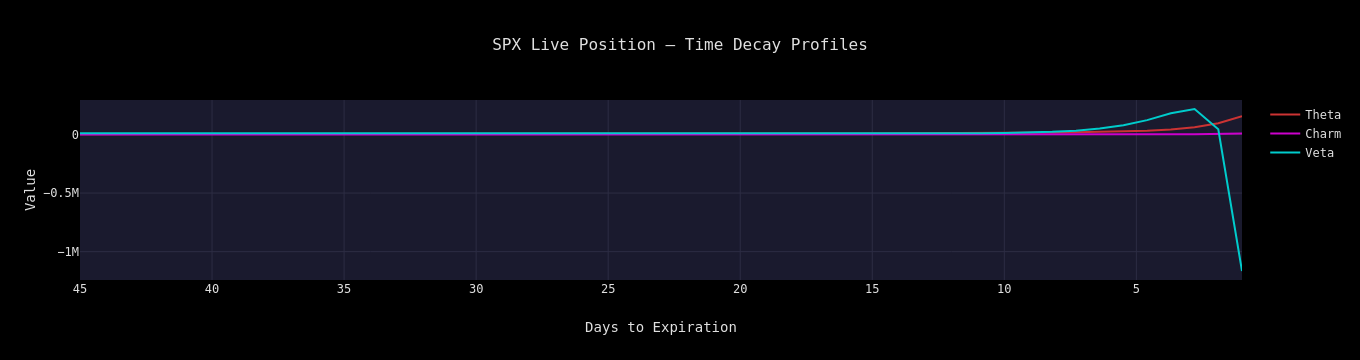

In [6]:
from options_analyzer.visualization.decay_charts import plot_decay_profiles

dte_range = np.linspace(1, 45, 50)
decay_greeks = analyzer.greeks_vs_time(position, spot, live_ivs if 'live_ivs' in dir() else initial_ivs, dte_range)

fig = plot_decay_profiles(
    dte_range,
    {"theta": decay_greeks["theta"], "charm": decay_greeks["charm"], "veta": decay_greeks["veta"]},
    title=f"{position.name} — Time Decay Profiles",
)
fig.show()

## 6. Greeks Summary Table

Full breakdown of all Greeks — per-leg and aggregated.

In [7]:
final_ivs = live_ivs if 'live_ivs' in dir() else initial_ivs
pos_greeks = analyzer.position_greeks(position, spot, final_ivs)

print(f"{'='*70}")
print(f"  {position.name} — Full Greeks Summary")
print(f"{'='*70}")

# Per-leg
for leg in position.legs:
    side = "LONG" if leg.side == PositionSide.LONG else "SHORT"
    label = f"{side} {leg.quantity}x {leg.contract.option_type.value.upper()} {leg.contract.strike}"
    lg = pos_greeks.per_leg.get(leg.contract.symbol)
    if lg:
        print(f"\n  {label}")
        print(f"    1st: D={lg.first_order.delta:>8.4f}  G={lg.first_order.gamma:>8.4f}  "
              f"T={lg.first_order.theta:>8.4f}  V={lg.first_order.vega:>8.4f}")
        print(f"    2nd: Va={lg.second_order.vanna:>8.5f}  Vo={lg.second_order.volga:>8.5f}  "
              f"Ch={lg.second_order.charm:>8.5f}")

# Aggregated
agg = pos_greeks.aggregated
print(f"\n  {'─'*60}")
print(f"  AGGREGATED")
print(f"    1st: D={agg.first_order.delta:>8.4f}  G={agg.first_order.gamma:>8.4f}  "
      f"T={agg.first_order.theta:>8.4f}  V={agg.first_order.vega:>8.4f}")
print(f"    2nd: Va={agg.second_order.vanna:>8.5f}  Vo={agg.second_order.volga:>8.5f}  "
      f"Ch={agg.second_order.charm:>8.5f}")
print(f"{'='*70}")

  SPX Live Position — Full Greeks Summary

  LONG 1x CALL 7000.0
    1st: D= 52.4556  G=  0.0928  T=-59412.3072  V=118000.8383
    2nd: Va=-0.00791  Vo= 1.44337  Ch=22.63438

  SHORT 1x CALL 6990.0
    1st: D=-53.3721  G= -0.0919  T=59920.4170  V=-117802.2877
    2nd: Va= 6.14360  Vo=-1540.74247  Ch=-19.93612

  LONG 1x PUT 6725.0
    1st: D=-27.6418  G=  0.0636  T=-41618.7000  V=99132.4864
    2nd: Va=-97.55601  Vo=171587.70555  Ch=-32.41178

  SHORT 2x PUT 6675.0
    1st: D= 50.1255  G= -0.1170  T=82886.1798  V=-188594.0985
    2nd: Va=206.14564  Vo=-410842.49298  Ch=76.07040

  LONG 1x PUT 6615.0
    1st: D=-22.2983  G=  0.0528  T=-40882.4884  V=88424.2836
    2nd: Va=-106.67113  Vo=240929.70052  Ch=-43.30876

  LONG 1x PUT 6975.0
    1st: D=-45.2812  G=  0.0905  T=-36365.3713  V=117396.8872
    2nd: Va=-14.94748  Vo=5251.73132  Ch=15.96591

  LONG 1x PUT 6865.0
    1st: D=-36.4420  G=  0.0788  T=-40191.4064  V=111329.9679
    2nd: Va=-64.99902  Vo=66776.24125  Ch=-9.68224

  SHORT 

## 7. Cleanup

In [ ]:
await tt_session.disconnect()
print("Session disconnected.")